In [1]:
import pandas as pd
import numpy as np
import os 

In [2]:
df = pd.read_csv("articles.csv")
df.head()

,author,claps,reading_time,link,title,text
0,Justin Lee,8.3K,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T..."
1,Conor Dewey,1.4K,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...
2,William Koehrsen,2.8K,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...
3,Gant Laborde,1.3K,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...
4,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...


In [3]:
import langdetect

def detect_language(text):
    return langdetect.detect(text)

df = pd.read_csv('articles.csv')
print("Nombre d'inputs avant suppression des textes non anglais : " + str(len(df)))

# créer une liste vide qui contiendra les indices des lignes à supprimer
indexes_to_delete = []

# parcourir chaque ligne du dataframe
for index, row in df.iterrows():

    lang = detect_language(row['text'][0:200])
    # si la valeur de l'attribut 'text' commence par un 'm'
    if lang != 'en':
    # ajouter l'index de cette ligne à la liste des indices à supprimer
        indexes_to_delete.append(index)

# supprimer les lignes du dataframe en utilisant la liste des indices à supprimer
df.drop(indexes_to_delete, inplace=True)

print("Nombre d'inputs après suppression des textes non anglais : " + str(len(df)))

Nombre d'inputs avant suppression des textes non anglais : 337
Nombre d'inputs après suppression des textes non anglais : 331


### PREPROCESSING


In [4]:
# REMOVE PUNCTUATION
import string

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

df["text"] = df["text"].apply(lambda row :remove_punctuation(row))
df["text"] = df["text"].apply(lambda row: row.lower())

In [5]:
# TOKENIZATION
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize

df["text"] = df["text"].apply(lambda x : word_tokenize(x))

In [6]:
# REMOVE STOP WORDS
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
df["text"] = df["text"].apply(lambda x: [w for w in x if not w in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leolamoureux/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# LEMMATIZATION
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

df["text"] = df["text"].apply(lambda x: [WordNetLemmatizer().lemmatize(w) for w in x])

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/leolamoureux/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
import re
import enchant

# Create a UK English dictionary using enchant
dictionary = enchant.Dict("en_GB")

# Define a regular expression pattern to match non-alphabetic characters
pattern = re.compile(r'[^a-zA-Z]')

# Remove all non-English words from the documents
filtered_documents = []
for doc in df["text"]:
    filtered_doc = []
    for word in doc:
        # Remove non-alphabetic characters from the word
        word = pattern.sub('', word)
        # Check if the word is in the English dictionary
        if word and dictionary.check(word):
            filtered_doc.append(word)
    filtered_documents.append(filtered_doc)

### TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()
documents = [' '.join(doc) for doc in filtered_documents]

# Fit the vectorizer on the documents and transform them into TF-IDF vectors
tfidf = vectorizer.fit_transform(documents)

# Get the feature names (words)
feature_names = vectorizer.get_feature_names()

# Create a DataFrame from the TF-IDF vectors
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=feature_names)

# Print the resulting DataFrame
print(tfidf_df)

     aah   ab  aback  abandoned  abbreviated  abilities   ability  ablation  \
0    0.0  0.0    0.0        0.0          0.0   0.000000  0.000000       0.0   
1    0.0  0.0    0.0        0.0          0.0   0.000000  0.019030       0.0   
2    0.0  0.0    0.0        0.0          0.0   0.000000  0.000000       0.0   
3    0.0  0.0    0.0        0.0          0.0   0.000000  0.000000       0.0   
4    0.0  0.0    0.0        0.0          0.0   0.000000  0.000000       0.0   
..   ...  ...    ...        ...          ...        ...       ...       ...   
326  0.0  0.0    0.0        0.0          0.0   0.000000  0.000000       0.0   
327  0.0  0.0    0.0        0.0          0.0   0.052112  0.030109       0.0   
328  0.0  0.0    0.0        0.0          0.0   0.000000  0.026217       0.0   
329  0.0  0.0    0.0        0.0          0.0   0.000000  0.000000       0.0   
330  0.0  0.0    0.0        0.0          0.0   0.000000  0.000000       0.0   

         able  abnormal  ...  zeroth  zest  zigzag 

/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Tokenize the documents
documents = [' '.join(document) for document in filtered_documents]

# Vectorize the documents using TF-IDF
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(documents)

# Fit a k-means clustering model to the vectors
kmeans = KMeans(n_clusters=3)
kmeans.fit(vectors)

# Predict the clusters for the documents
predicted_clusters = kmeans.predict(vectors)

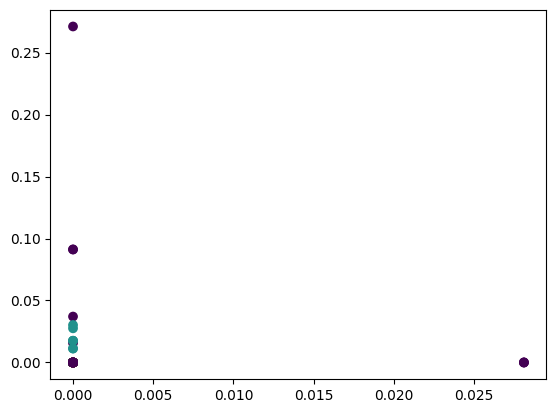

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the vectors to a two-dimensional array
vectors_array = vectors.toarray()

# Project the document vectors to the two most significant dimensions
X = vectors_array[:, 0]
Y = vectors_array[:, 1]

# Create a scatter plot of the documents
plt.scatter(X, Y, c=predicted_clusters)
plt.show()

In [27]:
import gensim

# Train a Word2Vec model on the sentences
model = gensim.models.Word2Vec(filtered_documents, vector_size=100, window=5, min_count=1, workers=4)

# Obtain the word vectors for each word in the list, preserving the original structure
vectors = [[model.wv.__getitem__(word) for word in sentence] for sentence in filtered_documents]